<img src="https://github.com/big-inpe/cap-423/blob/main/docs-site/images/cap.png?raw=true" align="right" width="120"/>


<div style="text-align: center;">
    <span style="justify-content: center;color:#336699;">
      <h2> Object-based and pixel-based time series classification for land use and cover mapping in Rondonia </h2>
    </span>
</div>
<hr style="border:2px solid #0077b9;">

<div style="text-align: center;font-size: 90%;">
    Pedro Brito and Felipe Carvalho
    <br/><br/>
    Graduate Program in Applied Computing - INPE/CAP 
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:pedrobritoufrpe@gmail.com">pedrobritoufrpe@gmail.com</a>, <a href="mailto:lipecaso@gmail.com">lipecaso@gmail.com</a>
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This notebook compared two classification approaches, pixel-based and object-based. The comparison was made using validation points.
</div>

## <span style="color:#336699">Import packages</span>

<hr style="border:1px solid #0077b9;">

In [1]:
#
# Import SITS package to produce classifications
#
library(sits)

#
# Import terra package to work with raster data
#
library(terra)

#
# Import sf package to work with vector data
#
library(sf)

#
# Set seed to ensure reproducibility
#
set.seed(123)

SITS - satellite image time series analysis.

Loaded sits v1.5.2.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.

Important: Please read "Release Notes for SITS 1.5.2" in
                https://github.com/e-sensing/sits.

terra 1.7.78

Linking to GEOS 3.12.1, GDAL 3.8.5, PROJ 9.4.0; sf_use_s2() is TRUE



## <span style="color:#336699">Define general functions</span>

<hr style="border:1px solid #0077b9;">

In [41]:
#
# Function for visualization tuning history
#
optimization_history <- function(tune) {
  acc <- sort(tune$accuracy, decreasing = FALSE)
  acc <- tibble::tibble(
    acc = acc,
    trial = seq_len(length(acc))
  )
  
  p <- ggplot2::ggplot(acc, ggplot2::aes(
    x = .data[["trial"]],
    y = .data[["acc"]]
  ))
  
  p <- p + 
    ggplot2::geom_smooth(
      formula = y ~ x,
      se      = FALSE,
      method  = "loess",
      na.rm   = TRUE
    )
  
  p <- p +
    ggplot2::theme(
      strip.placement = "outside",
      strip.text = ggplot2::element_text(
        colour = "black",
        size   = 11
      ),
      strip.background = ggplot2::element_rect(
        fill  = NA,
        color = NA
      )
    )
  
  p <- p + ggplot2::labs(x = "Trial", y = "Objective Value")
  p
}

#
# Define color palette
#
class_color <- tibble::tibble(name = character(), color = character())
class_color <- class_color |>
  tibble::add_row(name = "Bare_Soil", color = "#D7C49C") |>
  tibble::add_row(name = "Burned_Areas", color = "#EC7063") |>
  tibble::add_row(name = "Forest2", color = "#00B29E") |>
  tibble::add_row(name = "Forests", color = "#1E8449") |>
  tibble::add_row(name = "forest", color = "#1E8449") |>
  tibble::add_row(name = "forests", color = "#1E8449") |>
  tibble::add_row(name = "Forests4", color = "#229C59") |>
  tibble::add_row(name = "Highly_Degraded", color = "#BFD9BD") |>
  tibble::add_row(name = "Water", color = "#2980B9") |>
  tibble::add_row(name = "water", color = "#2980B9") |>
  tibble::add_row(name = "Wetlands", color = "#A0B9C8") |>
  tibble::add_row(name = "wetlands2", color = "#7CF4FA")


#
# Load the color table into `sits`
#
sits_colors_set(colors = class_color, legend = "class_color")

## <span style="color:#336699">Create data cube</span>

<hr style="border:1px solid #0077b9;">

In [4]:
#
# Define working year
#
y <- "2022"

#
# Cube directory
#
cube_dir <- "../data/output/RO/cube/"

#
# Cube bands
#
cube_bands <- c(
  "BLUE", "EVI", "GREEN", "NDVI", "NIR08", "RED", "SWIR16", "SWIR22", "CLOUD"
)

#
# Total of workers available
#
multicores <- 24

#
# Create cube directory
#
dir.create(cube_dir, recursive = TRUE, showWarnings = FALSE)

#
# Define working tile
#
tile <- "006008"

#
# Define dates
#
start_date <- paste0(y, "-01-01")
end_date <- paste0(y, "-12-31")

#
# Load cube
#
cube <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    tiles      = tile,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

#
# define cube directory
#
cube_dir_year <- paste0(cube_dir, y)

# create cube directory
dir.create(cube_dir_year, recursive = TRUE, showWarnings = FALSE)

#
# Downlaod images
#
cube <- sits_cube_copy(
    cube     = cube,
    multicores = multicores,
    output_dir = cube_dir_year
)

#
# Define cube directory
#
cube_dir_year_reg <- paste0(cube_dir, y, "_reg")

#
# Create cube directory
#
dir.create(cube_dir_year_reg, recursive = TRUE, showWarnings = FALSE)

#
# Regularize cube
#
cube <- sits_regularize(
    cube       = cube,
    period     = "P1M",
    res        = 30,
    tiles      = cube$tile,
    multicores = multicores,
    output_dir = cube_dir_year_reg
)

  |======================================================================| 100%


In [5]:
#
# Load local cube
#
cube <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir = "../data/output/RO/cube/2022_reg"
)

  |======================================================================| 100%


In [6]:
#
# View cube metadata
#
print(cube)

# A tibble: 1 × 11
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    LANDSAT-OLI-1… LANDSAT   OLI    0060… 3.89e6 4.10e6 1.01e7 1.03e7 "PRO…
# ℹ 1 more variable: file_info <list>


## <span style="color:#336699">Read Samples</span>

<hr style="border:1px solid #0077b9;">

In [7]:
#
# Define samples path
#
samples_file <- "../data/raw/samples/samples.rds"

#
# Load samples
#
samples <- readRDS(samples_file)

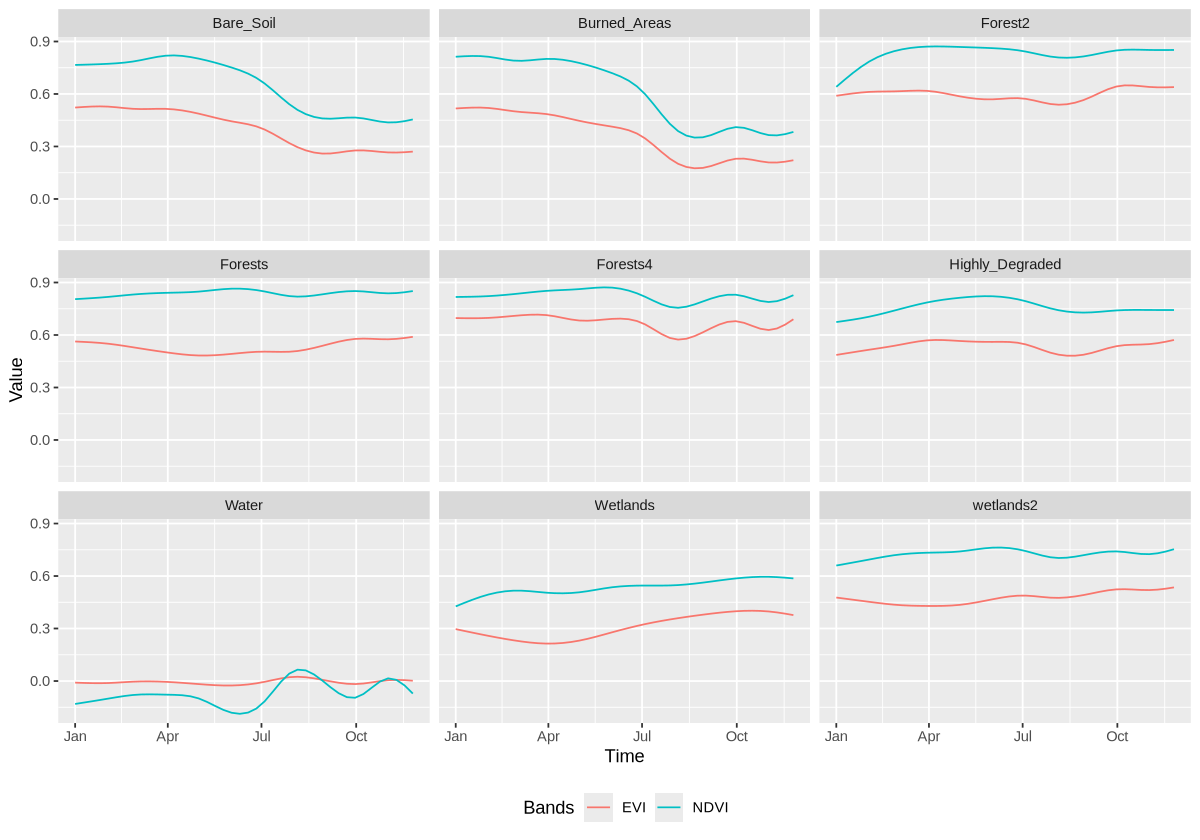

In [8]:
#
# View samples patterns
#
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sits_patterns(sits_select(samples, bands = c("EVI", "NDVI"))))

## <span style="color:#336699">Tune TempCNN model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Tune tempCNN model hiperparameters
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

In [ ]:
# 
# Define tuned path
#
tuning_dir <- "../data/output/RO/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE, showWarnings = FALSE)

# 
# Save tuned results
#
saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_ro.rds"))

In [9]:
# 
# Load tuned results
#
tuned_tempcnn <- readRDS("../data/output/RO/tune/tempcnn/tempcnn_ro.rds")

# 
# View best tuned params
#
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.924 0.911 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 2    0.913 0.898 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.911 0.895 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 4    0.911 0.895 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.910 0.894 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 6    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 7    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 8    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 9    0.908 0.891 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
10    0.907 0.890 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

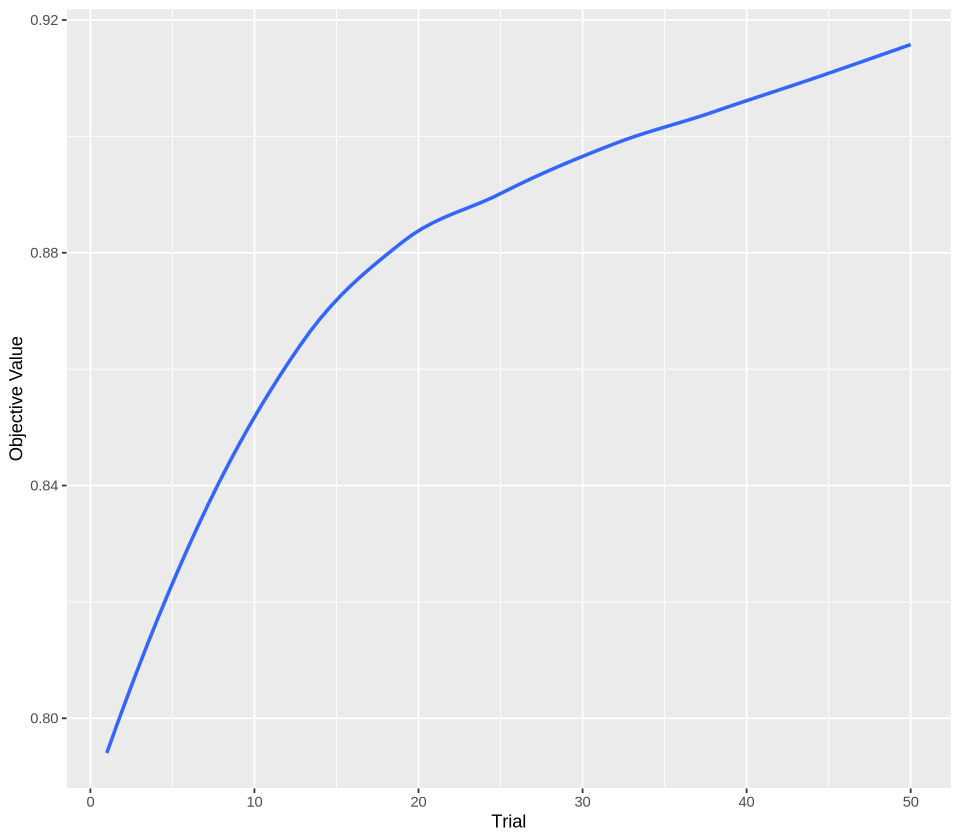

In [10]:
#
# Optimization history plot
#
options(repr.plot.width = 8, repr.plot.height = 7)
optimization_history(tuned_tempcnn)

## <span style="color:#336699">Train TempCNN model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Train tempCNN model with best hiperparameters found
#
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^7, 2^7, 2^7),
          cnn_kernels = c(5, 5, 5),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.000550),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [ ]:
#
# Define output directory
#
base_model_dir <- "../data/output/RO/model/"
tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

#
# Create directory
#
dir.create(base_model_dir, recursive = TRUE, showWarnings = FALSE)

#
# Save best model
#
saveRDS(tcnn_model, tcnn_dir)

In [11]:
#
# Read trained model
#
tcnn_model <- readRDS("../data/output/RO/model/tcnn_model.rds")

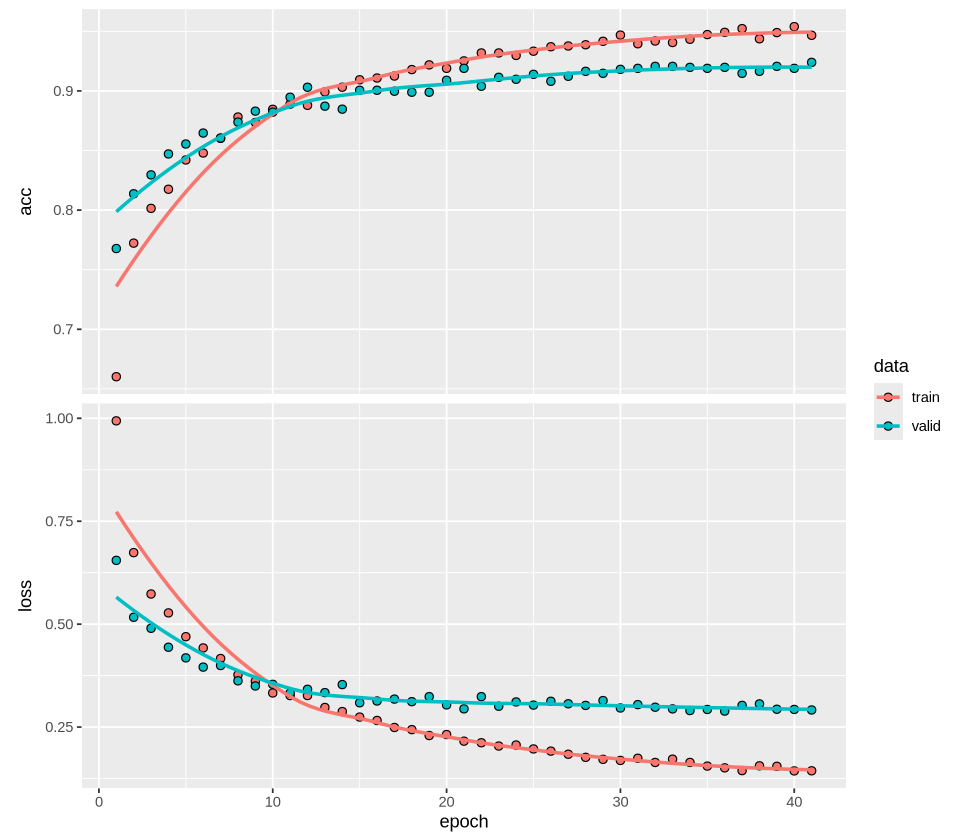

In [12]:
#
# Accuracy and validation curves
#
options(repr.plot.width = 8, repr.plot.height = 7)
plot(tcnn_model)

## <span style="color:#336699">Tune LightTAE model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Tune lightttae model 
#
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

In [ ]:
# 
# Define output directory
#
tuning_dir <- "../data/output/RO/tune/lighttae/"

# 
# Create directory
#
dir.create(tuning_dir, recursive = TRUE, showWarnings = FALSE)

# 
# Save model
#
saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_ro.rds"))

In [13]:
#
# Read tuned parameters
#
tuned_lighttae <- readRDS("../data/output/RO/tune/lighttae/lighttae_ro.rds")

In [14]:
# 
# View best tuned params
#
print(tuned_lighttae)

# A tibble: 50 × 14
   accuracy kappa acc        samples_validation epochs batch_size
      <dbl> <dbl> <list>     <list>              <dbl>      <dbl>
 1    0.905 0.889 <cnfsnMtr> <NULL>                150        128
 2    0.904 0.888 <cnfsnMtr> <NULL>                150        128
 3    0.899 0.882 <cnfsnMtr> <NULL>                150        128
 4    0.899 0.881 <cnfsnMtr> <NULL>                150        128
 5    0.899 0.881 <cnfsnMtr> <NULL>                150        128
 6    0.898 0.880 <cnfsnMtr> <NULL>                150        128
 7    0.898 0.880 <cnfsnMtr> <NULL>                150        128
 8    0.897 0.879 <cnfsnMtr> <NULL>                150        128
 9    0.894 0.876 <cnfsnMtr> <NULL>                150        128
10    0.894 0.876 <cnfsnMtr> <NULL>                150        128
# ℹ 40 more rows
# ℹ 8 more variables: validation_split <dbl>, optimizer <list>,
#   opt_hparams <list>, lr_decay_epochs <int>, lr_decay_rate <dbl>,
#   patience <int>, min_delta <dbl>, ve

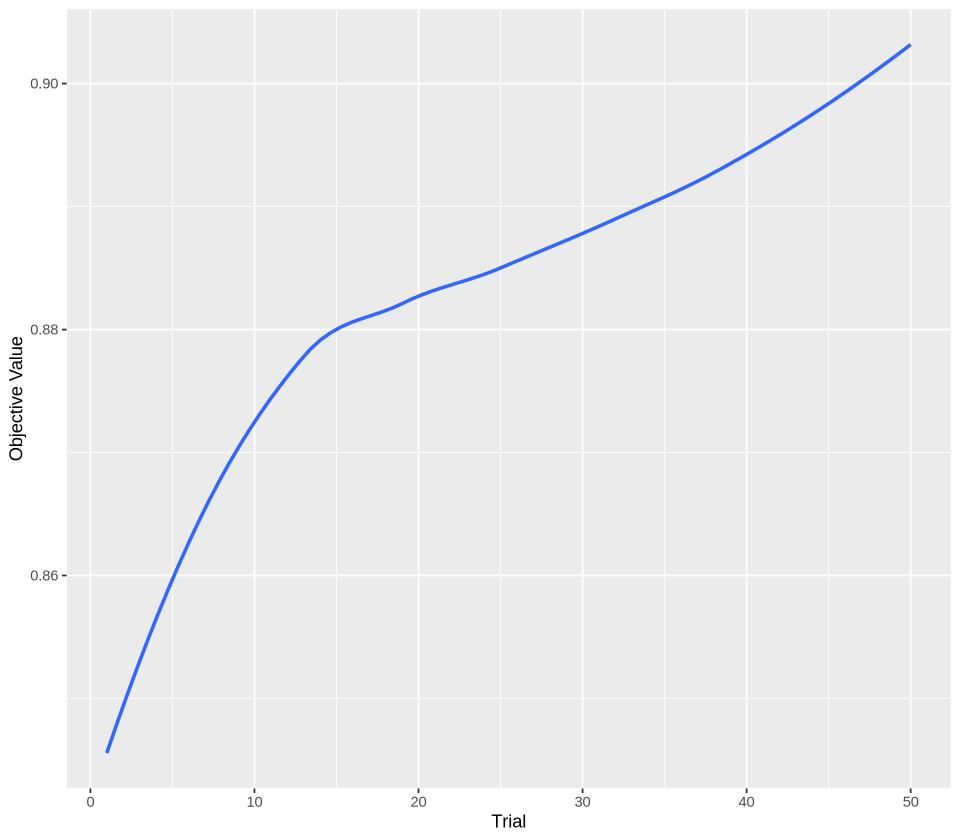

In [15]:
#
# Optimization history plot
#
options(repr.plot.width = 8, repr.plot.height = 7)
optimization_history(tuned_lighttae)

## <span style="color:#336699">Train LightTAE model</span>

<hr style="border:1px solid #0077b9;">

In [ ]:
#
# Train LightTAE model with best hiperparameters found
#
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.00147, weight_decay = 0.000246),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [ ]:
#
# Define output directory
#
base_model_dir <- "../data/output/RO/model/"
ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

#
# Save best model
#
saveRDS(lighttae_model, ltae_dir)

In [16]:
#
# Read trained model
#
lighttae_model <- readRDS("../data/output/RO/model/ltae_model.rds")

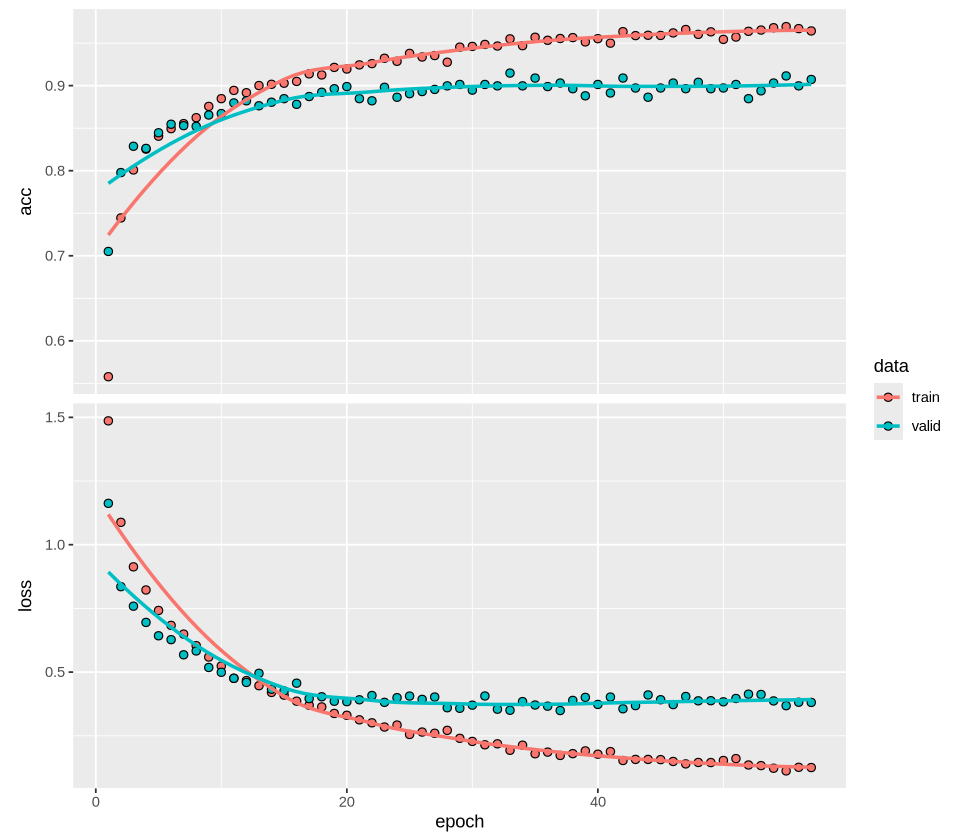

In [17]:
#
# Accuracy and validation curves
#
options(repr.plot.width = 8, repr.plot.height = 7)
plot(lighttae_model)

## <span style="color:#336699">Pixel-based classification - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [19]:
#
# Define output directory
#
output_dir <- "../data/output/RO/classifications/tccn"

#
# Define version name
#
results_version <- "tcnn-8cls"

#
# Create directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify data cube
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE
)

#
# Apply spatial smooth
#
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



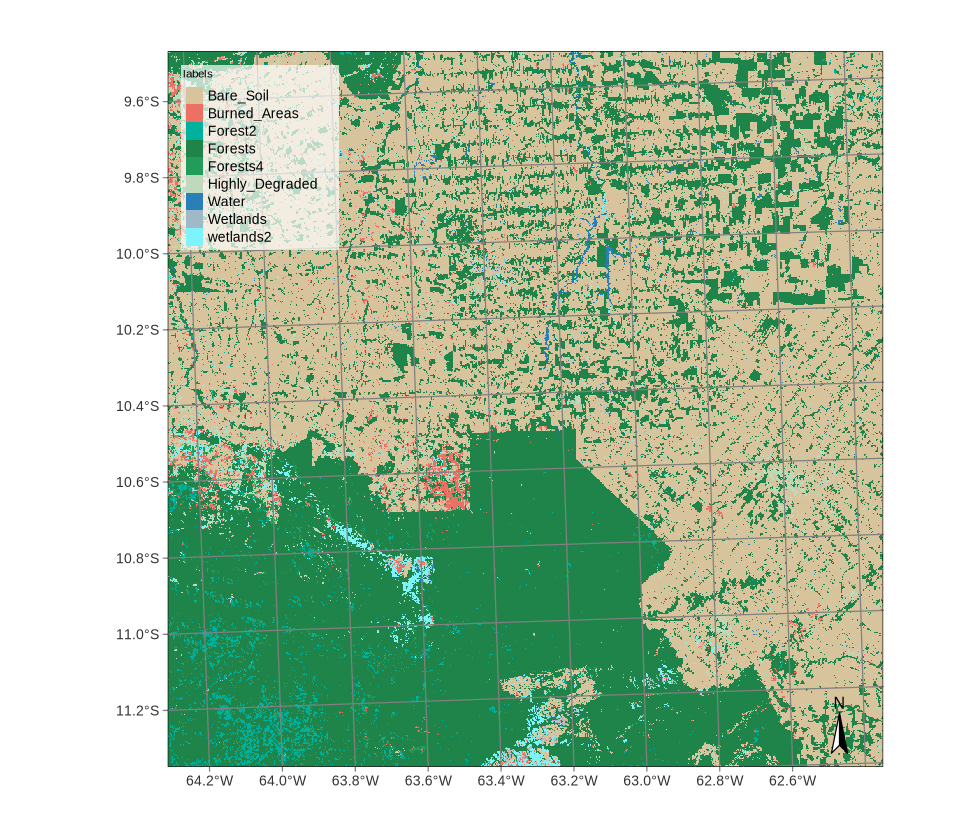

In [23]:
#
# View the classified tile
#
plot(class_cube)

## <span style="color:#336699">Pixel-based classification - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [25]:
#
# Define output directory
#
output_dir <- "../data/output/RO/classifications/lighttae"

#
# Define version name
#
results_version <- "lighttaeb-8cls"

#
# Create output directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify data cube
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

#
# Apply spatial smooth
#
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



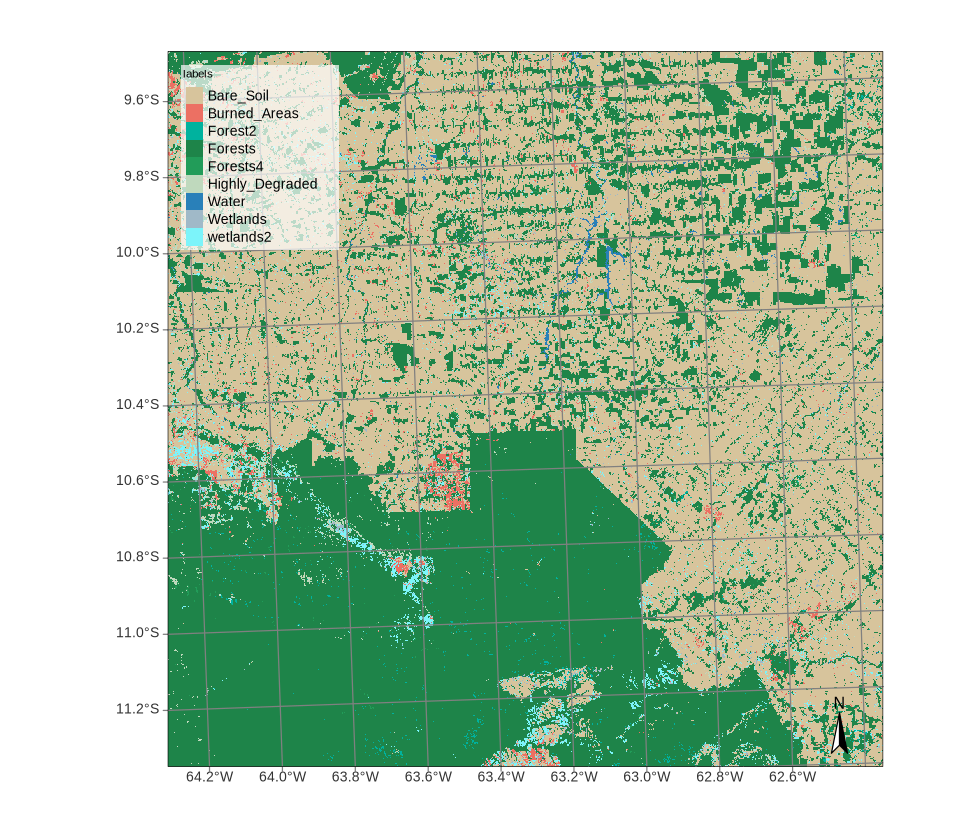

In [26]:
#
# View the classified tile
#
plot(class_cube)

## <span style="color:#336699">Apply Spatial-temporal segmentation</span>

<hr style="border:1px solid #0077b9;">

In [27]:
#
# Define output directory
#
segment_dir <- "../data/output/RO/segment/"

#
# Apply spatio-temporal segmentation in Sentinel-2 cube 
#
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Object-based classification - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [28]:
#
# Define output directory
#
output_dir <- "../data/output/RO/segment/tcnn"

#
# Define version name
#
results_version <- "tcnn-8cls-segments"

#
# Create directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify object-based data cube
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Object-based classification - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [29]:
#
# Define output directory
#
output_dir <- "../data/output/RO/segment/ltae"

#
# Define version name
#
results_version <- "ltae-8cls-segments"

#
# Create directory
#
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

#
# Classify object-based data cube
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 8,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

#
# Generate map
#
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

recovery mode: data already exists. To produce new data, change output_dir or version

recovery mode: data already exists. To produce new data, change output_dir or version



## <span style="color:#336699">Read validation samples</span>

<hr style="border:1px solid #0077b9;">

In [33]:
#
# Read validation samples
#
samples_val <- sf::st_read("../data/raw/RO/validation/validation_pts.gpkg", quiet = TRUE)

#
# Adjust labels in validation samples
#
samples_val <- samples_val |>
  dplyr::mutate(
    label = dplyr::case_when(
      class == "CR_QM" ~ "Burned_Areas",
      class == "CR_SE" ~ "Bare_Soil",
      class == "CR_VG" ~ "Highly_Degraded",
      class %in% c("For", "MSFor")  ~ "forest",
      class %in% c("water") ~ "water"
    )
)

#
# View the first 10 samples
#
print(samples_val)

Simple feature collection with 319 features and 5 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -64.29124 ymin: -11.3813 xmax: -62.30947 ymax: -9.485726
Geodetic CRS:  WGS 84
First 10 features:
   class LTAE1 RFor1 TCNN1                        geom        label
1  CR_SE     1     1     1  POINT (-62.6737 -11.01375)    Bare_Soil
2  CR_SE     1     1     1 POINT (-64.06948 -10.21668)    Bare_Soil
3  CR_SE     1     1     1 POINT (-63.97642 -10.08569)    Bare_Soil
4  CR_SE     1     1     1 POINT (-62.40085 -9.773946)    Bare_Soil
5  CR_SE     1     1     1 POINT (-62.40983 -10.49376)    Bare_Soil
6  CR_SE     1     1     1 POINT (-62.77443 -10.84041)    Bare_Soil
7  CR_SE     1     1     1 POINT (-62.91036 -9.543613)    Bare_Soil
8  CR_SE     1     1     1   POINT (-62.50856 -10.882)    Bare_Soil
9  CR_SE     1     1     1 POINT (-62.36737 -10.86412)    Bare_Soil
10 CR_QM     6     6     1 POINT (-63.54695 -10.02226) Burned_Areas


## <span style="color:#336699"> Validation pixel-based - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [32]:
#
# Define model labels
#
labels <- sits_labels(tcnn_model)
names(labels) <- seq_len(length(labels))

In [34]:
#
# Load tcnn classification
#
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/classifications/tccn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls"
)

#
# Define mask directory
#
out_dir <- "../data/output/RO/validation/tcnn"

#
# Create mask directory
#
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

#
# Mask forest and water areas
#
masked_tcnn <- sits_reclassify(
    cube = class_tcnn,
    mask = class_tcnn,
    rules = list(
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = out_dir
)

#
# Compute map accuracy
#
acc_tcnn <- sits_accuracy(
    data = masked_tcnn,
    validation = samples_val[, "label"],
    method = "pixel"
)

  |======================================================================| 100%


recovery mode: data already exists. To produce new data, change output_dir or version



In [39]:
#
# Print CNN pixel-based classification
#
acc_tcnn

Confusion Matrix and Statistics

                 Reference
Prediction        Bare_Soil Burned_Areas Highly_Degraded water forest
  Bare_Soil             100           10               3     0      0
  Burned_Areas            0            8               4     0      0
  Highly_Degraded         1            4              11     0      0
  water                   0            1               0     7      0
  forest                  1            0               4     0    165

Overall Statistics
                            
 Accuracy : 0.9122          
   95% CI : (0.8756, 0.9409)
                            
    Kappa : 0.8548          

Statistics by Class:

                          Class: Bare_Soil Class: Burned_Areas
Prod Acc (Sensitivity)              0.9804              0.3478
Specificity                         0.9401              0.9865
User Acc (Pos Pred Value)           0.8850              0.6667
Neg Pred Value                      0.9903              0.9511
F1 score         

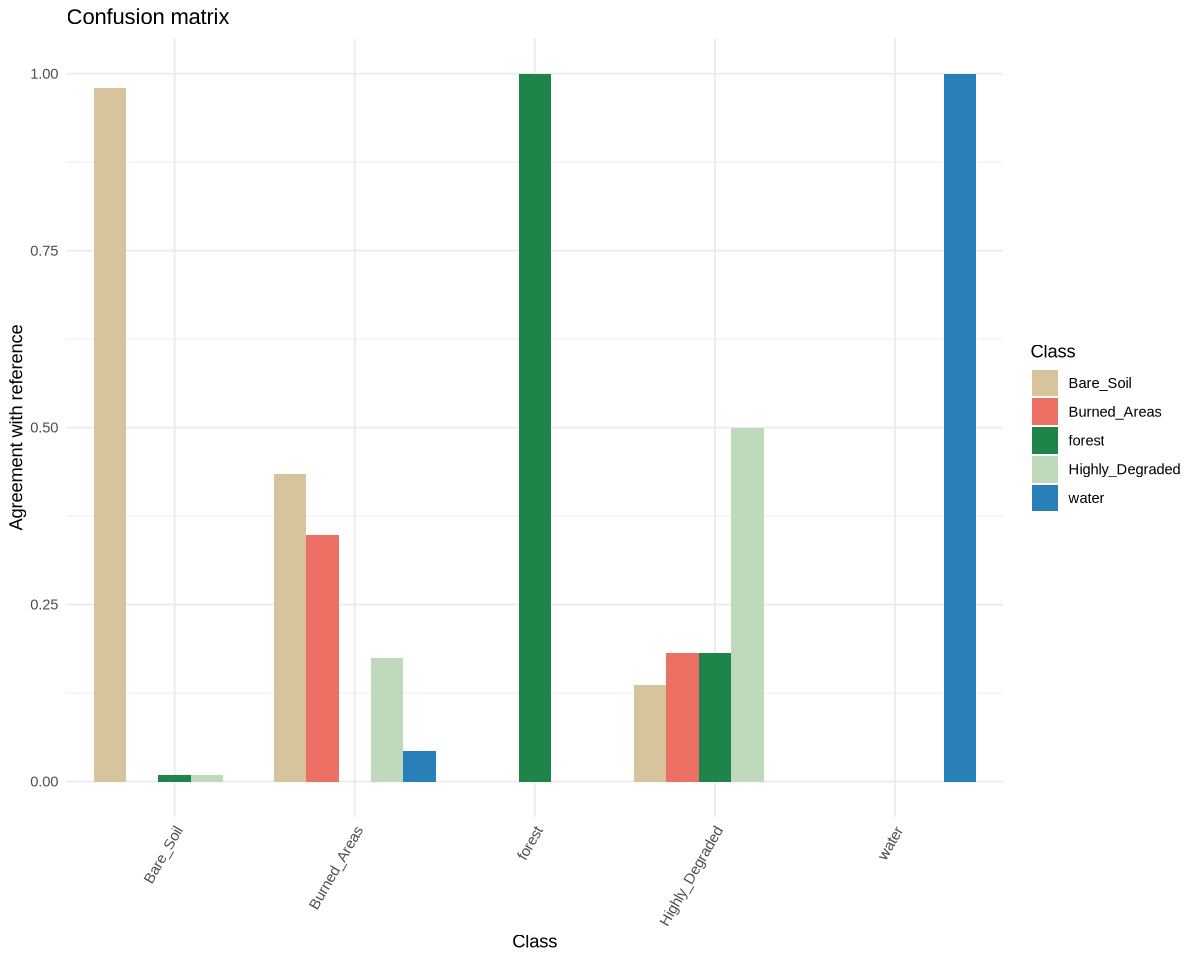

In [42]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_tcnn)

## <span style="color:#336699"> Validation pixel-based - LightTAE</span>

<hr style="border:1px solid #0077b9;">

In [43]:
#
# Define classification cube
#
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/classifications/lighttae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls"
)

#
# Define output mask directory
#
out_dir <- "../data/output/RO/validation/lighttae"

#
# Create mask directoty
#
dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

#
# Mask forest and water areas
#
masked_ltae <- sits_reclassify(
    cube = class_ltae,
    mask = class_ltae,
    rules = list(
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = out_dir
)

#
# Compute map accuracy
#
acc_ltae <- sits_accuracy(
    data = masked_ltae,
    validation = samples_val[, "label"],
    method = "pixel"
)

  |======================================================================| 100%


recovery mode: data already exists. To produce new data, change output_dir or version



In [44]:
#
# Print LTAE pixel-based classification
#
acc_ltae

Confusion Matrix and Statistics

                 Reference
Prediction        Bare_Soil Burned_Areas Highly_Degraded water forest
  Bare_Soil             100           10               4     0      0
  Burned_Areas            0           10               2     0      0
  Highly_Degraded         0            3               5     0      0
  water                   0            0               0     7      0
  forest                  2            0              11     0    165

Overall Statistics
                            
 Accuracy : 0.8997          
   95% CI : (0.8613, 0.9304)
                            
    Kappa : 0.8306          

Statistics by Class:

                          Class: Bare_Soil Class: Burned_Areas
Prod Acc (Sensitivity)              0.9804              0.4348
Specificity                         0.9355              0.9932
User Acc (Pos Pred Value)           0.8772              0.8333
Neg Pred Value                      0.9902              0.9577
F1 score         

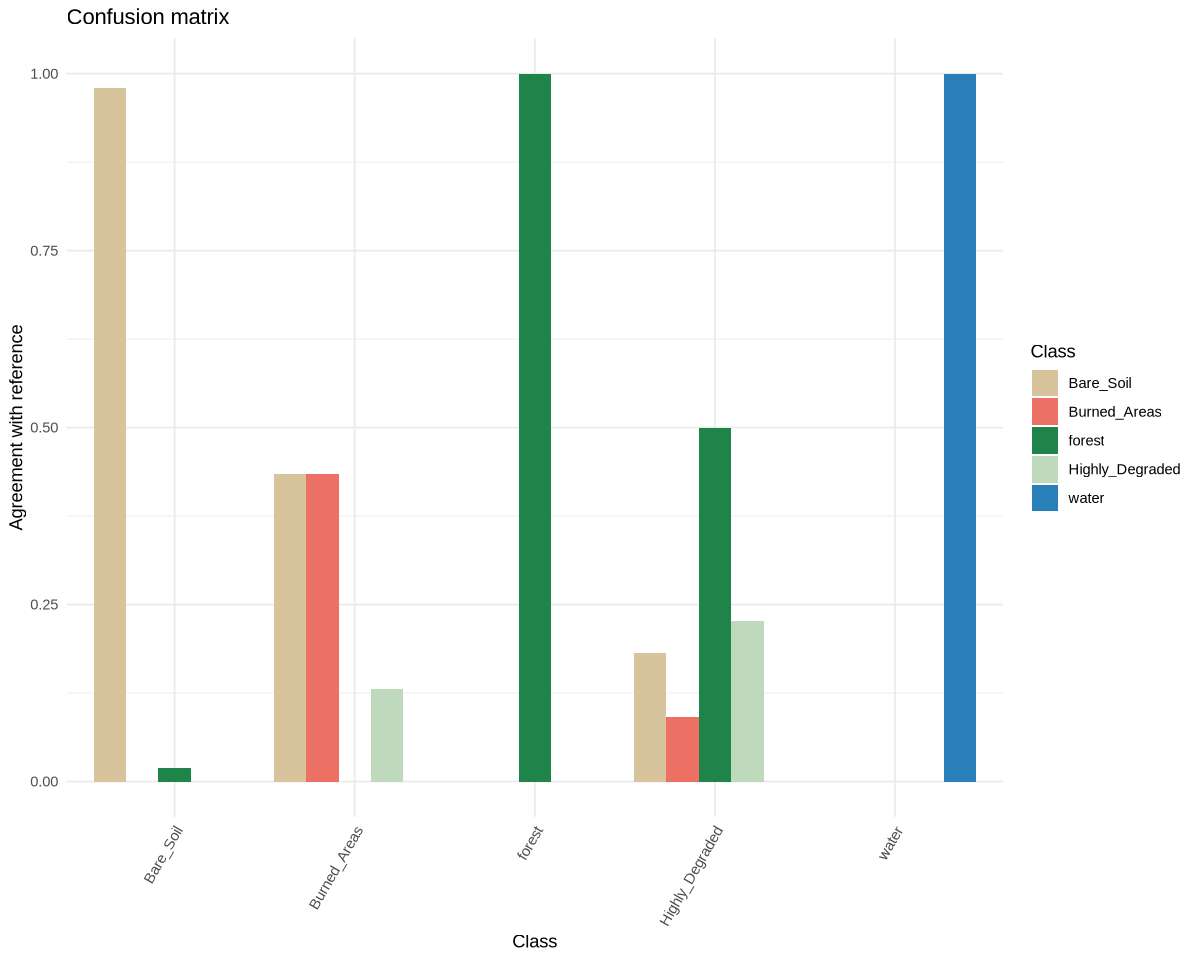

In [45]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_ltae)

## <span style="color:#336699"> Validation object-based - TCNN</span>

<hr style="border:1px solid #0077b9;">

In [47]:
#
# Read object-based classification
#
class_object_tcnn <- sf::st_read(
    "../data/output/RO/segment/tcnn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments.gpkg",
    quiet = TRUE
)

#
# Define a rast template
#
rast_template <- terra::rast("../data/output/RO/classifications/tccn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls.tif")

#
# Creating a new column with interger values representing classes
#
class_object_tcnn <- class_object_tcnn |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Bare_Soil" ~ 1,
      class == "Burned_Areas" ~ 2,
      class == "Forest2" ~ 3,
      class == "Forests" ~ 4,
      class == "Forests4" ~ 5,
      class == "Highly_Degraded" ~ 6,
      class == "Water" ~ 7,
      class == "Wetlands" ~ 8,
      class == "wetlands2" ~ 9
    )
)

#
# Rasterize classified polygons
#
rasterize_tcnn <- terra::rasterize(
    x = terra::vect(class_object_tcnn), 
    y = rast_template, 
    field = "label_val"
)

#
# Write rasterized polygons
#
terra::writeRaster(
    x = rasterize_tcnn, 
    filename = "../data/output/RO/segment/tcnn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U",
    overwrite = FALSE
)

In [48]:
#
# Define classification cube
#
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/segment/tcnn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls-segments-rasterize"
)

#
# Mask forest and water areas
#
masked_tcnn <- sits_reclassify(
    cube = class_tcnn,
    mask = class_tcnn,
    rules = list(
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = "../data/output/RO/segment/tcnn/",
    version = "tcnn-8cls-segments-rasterize-reclassified"
)

#
# Compute map accuracy
#
acc_tcnn <- sits_accuracy(
    data = masked_tcnn,
    validation = samples_val[, "label"],
    method = "pixel"
)

  |======================================================================| 100%


recovery mode: data already exists. To produce new data, change output_dir or version



In [49]:
#
# Print TCNN object-based classification
#
acc_tcnn

Confusion Matrix and Statistics

                 Reference
Prediction        Bare_Soil Burned_Areas Highly_Degraded water forest
  Bare_Soil             100            7               5     0      0
  Burned_Areas            0            9               3     0      0
  Highly_Degraded         1            7               6     0      0
  water                   0            0               0     7      0
  forest                  1            0               8     0    165

Overall Statistics
                            
 Accuracy : 0.8997          
   95% CI : (0.8613, 0.9304)
                            
    Kappa : 0.8326          

Statistics by Class:

                          Class: Bare_Soil Class: Burned_Areas
Prod Acc (Sensitivity)              0.9804              0.3913
Specificity                         0.9447              0.9899
User Acc (Pos Pred Value)           0.8929              0.7500
Neg Pred Value                      0.9903              0.9544
F1 score         

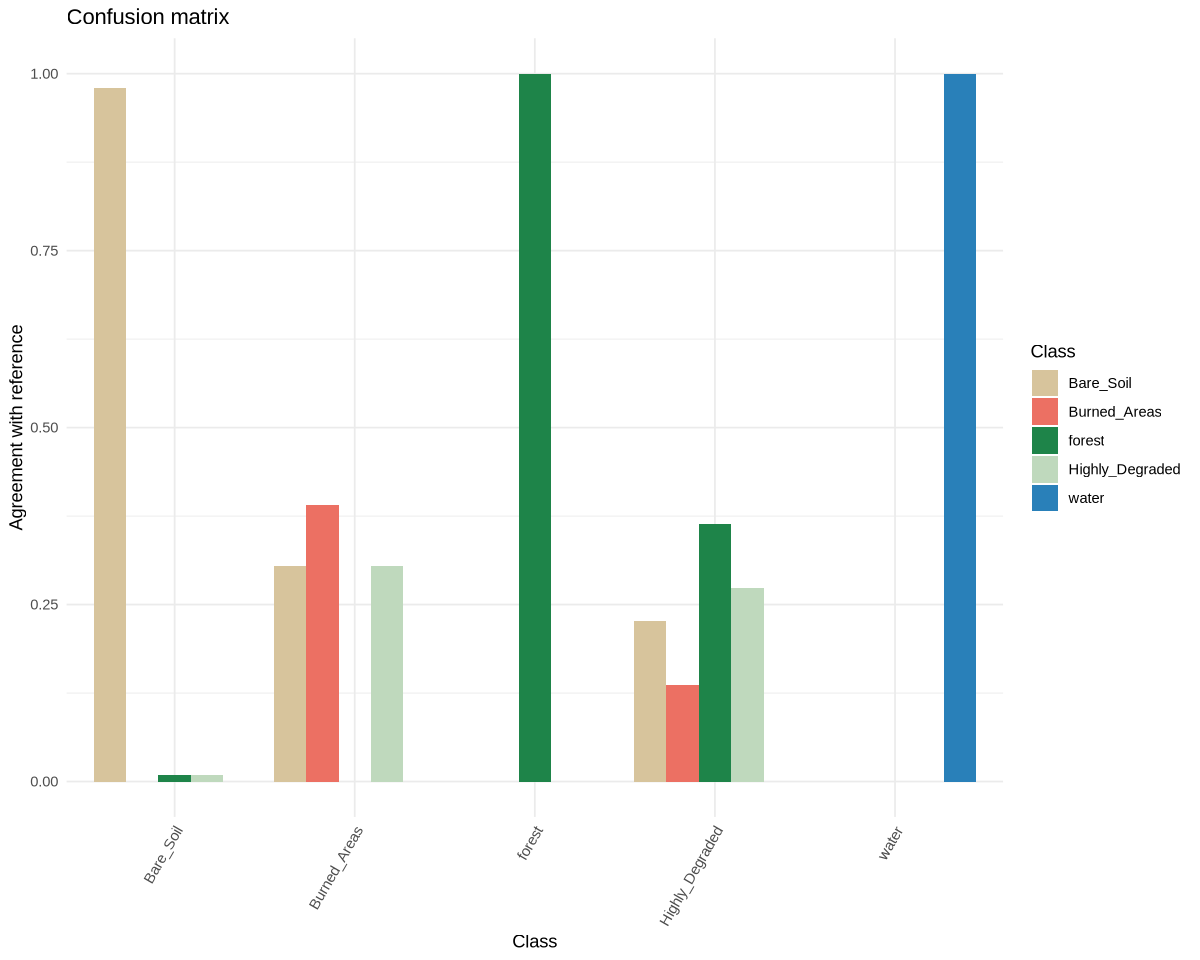

In [50]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_tcnn)

## <span style="color:#336699"> Validation object-based - LTAE</span>

<hr style="border:1px solid #0077b9;">

In [52]:
#
# Read object-based classification
#
class_object_ltae <- sf::st_read(
    "../data/output/RO/segment/ltae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments.gpkg",
    quiet = TRUE
)

#
# Define a rast template
#
rast_template <- terra::rast("../data/output/RO/classifications/lighttae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_lighttaeb-8cls.tif")

#
# Creating a new column with interger values representing classes
#
class_object_ltae <- class_object_ltae |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Bare_Soil" ~ 1,
      class == "Burned_Areas" ~ 2,
      class == "Forest2" ~ 3,
      class == "Forests" ~ 4,
      class == "Forests4" ~ 5,
      class == "Highly_Degraded" ~ 6,
      class == "Water" ~ 7,
      class == "Wetlands" ~ 8,
      class == "wetlands2" ~ 9
    )
)

#
# Rasterize classified polygons
#
rasterize_ltae <- terra::rasterize(
    x = terra::vect(class_object_ltae), 
    y = rast_template, 
    field = "label_val"
)

#
# Write rasterized polygons
#
terra::writeRaster(
    x = rasterize_ltae, 
    filename = "../data/output/RO/segment/ltae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [53]:
#
# Define classification cube
#
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/segment/ltae/",
    bands      = "class",
    labels     = labels,
    version    = "ltae-8cls-segments-rasterize"
)

#
# Mask forest and water areas
#
masked_ltae <- sits_reclassify(
    cube = class_ltae,
    mask = class_ltae,
    rules = list(
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = "../data/output/RO/segment/ltae/",
    version = "ltae-8cls-segments-rasterize-reclassified"
)

#
# Compute map accuracy
#
acc_ltae <- sits_accuracy(
    data = masked_ltae,
    validation = samples_val[, "label"],
    method = "pixel"
)

  |======================================================================| 100%


recovery mode: data already exists. To produce new data, change output_dir or version



In [54]:
#
# Print LTAE object-based classification
#
acc_ltae

Confusion Matrix and Statistics

                 Reference
Prediction        Bare_Soil Burned_Areas Highly_Degraded water forest
  Bare_Soil             100            8               6     0      0
  Burned_Areas            0           14               3     0      0
  Highly_Degraded         0            1               3     0      1
  water                   0            0               0     7      0
  forest                  2            0              10     0    164

Overall Statistics
                           
 Accuracy : 0.9028         
   95% CI : (0.8649, 0.933)
                           
    Kappa : 0.8367         

Statistics by Class:

                          Class: Bare_Soil Class: Burned_Areas
Prod Acc (Sensitivity)              0.9804              0.6087
Specificity                         0.9355              0.9899
User Acc (Pos Pred Value)           0.8772              0.8235
Neg Pred Value                      0.9902              0.9702
F1 score              

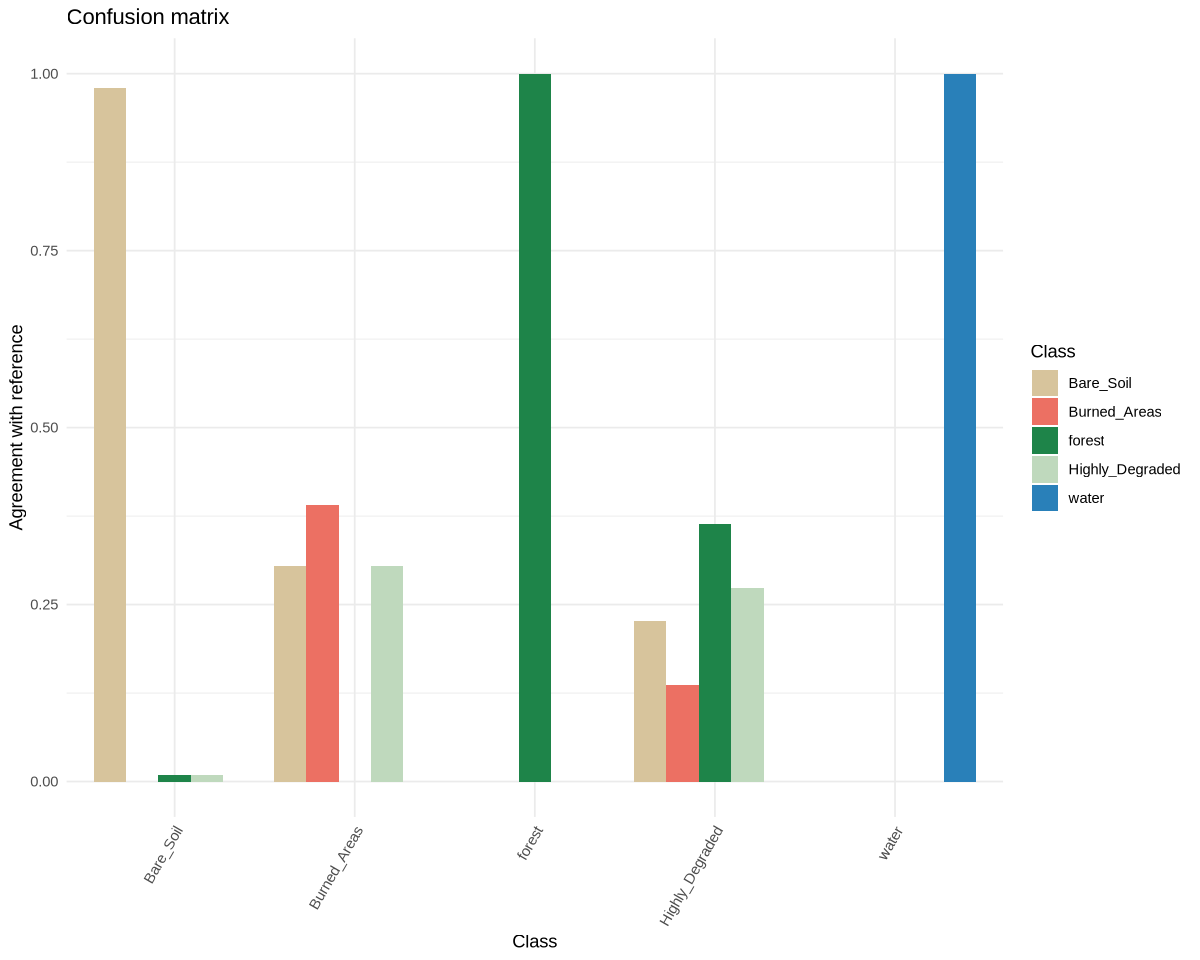

In [55]:
#
# Confusion between classes
#
options(repr.plot.width = 10, repr.plot.height = 8)
plot(acc_tcnn)